In [1]:
# 1. Create a massive list of possible activation functions
# 2. Iteratively create a graph for the target network using random activations and connectivity
# 3. See how well neural networks of different sizes and activation functions can solve it
#    Here I'm really just looking for diversity in the solutions.
# 4. Then try the same thing, but connect all hidden units to the output.
# 5. Try the same thing, but use all of the hidden units generated by all units.


# Progression of things to look at:
# - Initializations
# - Activations
# - Sparsity
# - Small world sparsity

In [2]:
import random
from typing import Any, Dict, List, Optional, Type, Tuple

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sparselinear as sl
import torch
from torch import nn
import torch.optim as optim
from torch.nn import functional as F

from phd.feature_search.core.idbd import IDBD
from phd.feature_search.core.models.base import LTU, FTA
from phd.feature_search.core.experiment_helpers import StandardizationStats, standardize_targets

In [3]:
class SinActivation(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.sin(x)
    
class NormActivation(nn.Module):
    def __init__(self, decay_rate: float = 0.99):
        super().__init__()
        self.stats = StandardizationStats(gamma=decay_rate)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out, self.stats = standardize_targets(x, self.stats)
        return out

In [4]:
activation_functions = {
    'relu': nn.ReLU,
    'sigmoid': nn.Sigmoid,
    'tanh': nn.Tanh,
    'elu': nn.ELU,
    'leaky_relu': nn.LeakyReLU,
    'swish': nn.SiLU,
    'gelu': nn.GELU,
    'selu': nn.SELU,
    'softplus': nn.Softplus,
    'softsign': nn.Softsign,
    'linear': nn.Identity,
    'ltu': LTU,
    'fta': FTA,
    'sin': SinActivation,
    'norm': NormActivation,
}

In [5]:
class RandomNetwork(nn.Module):
    def __init__(
        self,
        input_dim: int,
        n_hidden_activations: int,
        activation_functions: Dict[str, Type[nn.Module]],
    ):
        super().__init__()
        self.input_dim = input_dim
        self.n_hidden_activations = n_hidden_activations
        self.activation_functions = activation_functions
        self.max_connections_per_node = input_dim // 2
        
        self.activations, self.node_input_ids = self._generate_random_network(
            input_dim, n_hidden_activations, self.max_connections_per_node, activation_functions)
        
        n_inputs_per_node = torch.tensor([len(ids) for ids in self.node_input_ids])
        bounds = torch.sqrt(3 / n_inputs_per_node).reshape(n_hidden_activations, 1, 1) # Kaiming uniform
        self.weights = torch.rand(n_hidden_activations, 1, self.max_connections_per_node) * 2 * bounds - bounds
        self.weights = nn.Parameter(self.weights)
    
    def _generate_random_network(
        self,
        input_dim: int,
        n_hidden_activations: int,
        max_connections_per_node: int,
        activation_functions: Dict[str, Type[nn.Module]],
    ) -> Tuple[List[nn.Module], List[List[int]]]:
        """Generates a random network structure with specified input dimension and number of hidden activations.
        
        Args:
            input_dim: Number of input dimensions
            n_hidden_activations: Number of hidden activation nodes to generate
            activation_functions: Dictionary mapping activation names to activation classes
            
        Returns:
            Tuple containing:
                - List of activation modules
                - List of input indices for each activation node
        """
        n_hidden_units = input_dim
        activations = []
        node_input_ids = []
        
        for i in range(n_hidden_activations):
            activation_type = random.choice(list(activation_functions.keys()))
            n_inputs = random.randint(1, input_dim)
            if activation_type == 'fta':
                activations.append(FTA(1))
                n_outputs = 20
            else:
                activations.append(activation_functions[activation_type]())
                n_outputs = 1
            
            n_connections = random.randint(1, max_connections_per_node)
            input_ids = random.sample(range(n_hidden_units), n_connections)
            node_input_ids.append(input_ids)
            n_hidden_units += n_outputs
            
        return activations, node_input_ids

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        all_values = inputs.clone() # (batch_size, input_dim)
        for i, activation in enumerate(self.activations):
            values = all_values[:, self.node_input_ids[i]] # (batch_size, n_node_inputs)
            weights = self.weights[i, :, :values.shape[1]] # (1, n_node_inputs)
            preactivation = values @ weights.T # (batch_size, 1)
            postactivation = activation(preactivation)
            all_values = torch.cat([all_values, postactivation], dim=1)
        print(all_values.shape)
        return all_values

In [6]:
def create_mlp(
    layer_sizes: List[int],
    activation_class: Type[nn.Module],
    sparsity_rate: float = 0.0,
    small_world_sparsity: bool = False,
    bias: bool = True,
    seed: Optional[int] = None,
) -> nn.Sequential:
    """Create a Multi-Layer Perceptron (MLP) with specified architecture.
    
    Args:
        layer_sizes: List of integers representing the size of each layer,
            including input and output layers. For example, [784, 128, 64, 10]
            creates a network with input size 784, two hidden layers of 128 and 64
            neurons, and output size 10.
        activation_class: PyTorch activation function class (e.g., nn.ReLU,
            nn.Tanh, nn.Sigmoid, nn.LeakyReLU).
        sparsity_rate: The sparsity rate to apply to the linear layers.
        bias: Whether to include bias terms in linear layers.
        seed: Optional random seed for reproducibility.
    
    Returns:
        nn.Sequential: A PyTorch Sequential model representing the MLP.
    
    Raises:
        ValueError: If layer_sizes has fewer than 2 elements (input and output).
        ValueError: If any layer size is not positive.
    """
    if len(layer_sizes) < 2:
        raise ValueError(
            "layer_sizes must contain at least 2 elements (input and output)"
        )
    
    if any(size <= 0 for size in layer_sizes):
        raise ValueError("All layer sizes must be positive integers")
    
    if seed is not None:
        torch.manual_seed(seed)
    
    layers = []
    
    for i in range(len(layer_sizes) - 1):
        # Add linear layer
        if sparsity_rate > 0:
            new_layer = sl.SparseLinear(
                in_features = layer_sizes[i],
                out_features = layer_sizes[i + 1],
                bias = bias and i < len(layer_sizes) - 2,
                sparsity = sparsity_rate,
                small_world = small_world_sparsity,
            )
        else:
            new_layer = nn.Linear(
                in_features = layer_sizes[i],
                out_features = layer_sizes[i + 1],
                bias = bias and i < len(layer_sizes) - 2,
            )
        
        layers.append(new_layer)
        
        # Add activation function (except for the last layer)
        if i < len(layer_sizes) - 2:
            layers.append(activation_class())
    
    return nn.Sequential(*layers)

In [7]:
def train_model(
    model: nn.Module,
    train_inputs: torch.Tensor,
    train_outputs: torch.Tensor,
    repr_step_size: float,
    batch_size: int,
    print_freq: int = 1000,
    log_freq: int = 1000,
) -> Tuple[List[float], List[float]]:
    """Train a model and return training and test losses."""
    # output_optimizer = IDBD(
    #     params = model[-1].parameters(),
    #     meta_lr = 0.005,
    #     init_lr = 0.01,
    #     version = 'squared_grads',
    #     autostep = True,
    # )
    # if len(model) > 1:
    repr_optimizer = optim.Adam(model.parameters(), lr=repr_step_size)
    # else:
    #     repr_optimizer = None
    
    train_losses = []
    errors = []
    
    n_train_batches = len(train_inputs) // batch_size
    
    running_train_loss = 0.0
    print_loss_sum = 0.0
    step = 0
    
    for step in range(n_train_batches):
        # Get batch
        start_idx = step * batch_size
        end_idx = start_idx + batch_size
            
        batch_inputs = train_inputs[start_idx:end_idx]
        batch_outputs = train_outputs[start_idx:end_idx]
        
        outputs = model(batch_inputs)
        loss = F.mse_loss(outputs, batch_outputs)
        
        with torch.no_grad():
            batch_errors = (batch_outputs - outputs).view(-1).tolist()
            errors.extend(batch_errors)
        
        # Backward pass
        # output_optimizer.zero_grad()
        if repr_optimizer is not None:
            repr_optimizer.zero_grad()
        
        loss.backward() # retain_graph=True)
        
        # output_optimizer.step(outputs)
        if repr_optimizer is not None:
            repr_optimizer.step()
        
        # Accumulate running loss
        running_train_loss += loss.item()
        print_loss_sum += loss.item()
        
        if (step + 1) % print_freq == 0:
            print(f"Step {step+1}: Loss = {print_loss_sum / print_freq:.6f}")
            print_loss_sum = 0.0
        
        # Log periodically
        if (step + 1) % log_freq == 0:
            # Calculate average training loss
            avg_train_loss = running_train_loss / log_freq
            train_losses.append(avg_train_loss)
            
            # Reset running stats
            running_train_loss = 0.0
    
    return {
        'losses': train_losses,
        'errors': errors,
    }

In [16]:
def plot_1var_ablation_results(
    results_dict: Dict[Any, Dict[str, List[float]]],
    ablation_variable: str,
    figsize: Tuple[int, int] = (10, 6)
):
    """Plot training curves comparing different values of a single ablated variable.
    
    Args:
        results_dict: Dictionary mapping ablation values to results_dict containing
            'losses' list
        ablation_variable: Name of the variable that was ablated
        figsize: Figure size (width, height) in inches
    """
    # Extract unique ablation values
    ablation_values = sorted(list(results_dict.keys()))
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Define colors for different ablation values
    colors = plt.cm.Set1(np.linspace(0, 1, len(ablation_values)))
    
    # Find global min and max for consistent axis limits
    all_losses = []
    for result in results_dict.values():
        all_losses.extend(result['losses'])

    y_min = min(all_losses)
    y_max = max(all_losses)

    # Add padding to y-axis, using multiplicative padding for log scale
    y_min = y_min / 1.5  # Divide by >1 to extend lower bound
    y_max = y_max * 1.1  # Multiply by >1 to extend upper bound

    # Get number of steps from first result's losses length
    n_steps = len(next(iter(results_dict.values()))['losses'])
    steps = list(range(1, n_steps + 1))

    # Plot each ablation value with a different color
    for i, ablation_val in enumerate(ablation_values):
        result = results_dict[ablation_val]
        losses = result['losses']
        
        ax.plot(steps, losses, 
                label=f'{ablation_variable}={ablation_val}', 
                color=colors[i], 
                alpha=0.8,
                linewidth=2)
    
    ax.set_xlabel('Step')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training Loss vs {ablation_variable}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Set y-axis to log scale
    ax.set_yscale('log')
    
    # Set consistent axis limits
    ax.set_ylim(y_min, y_max)
    ax.set_xlim(1, n_steps)

    plt.tight_layout()
    plt.show()

    # Print final results summary
    print("\nFinal Results Summary:")
    print("=" * 50)
    for ablation_val in ablation_values:
        result = results_dict[ablation_val]
        final_loss = result['losses'][-1]
        print(f"{ablation_variable}={ablation_val}  --  Final Loss: {final_loss:.6f}")


def plot_2var_ablation_results(
    results_dict: Dict[Tuple[Any, Any], Dict[str, List[float]]],
    row_variable: str,
    col_variable: str,
    figsize: Tuple[int, int] = (15, 12)
):
    """Plot a grid of training curves comparing different model configurations.
    
    Args:
        results_dict: Dictionary mapping (row_val, col_val) tuples to results_dict containing
            'train_losses' and 'test_losses' lists
        row_variable: Name of the variable that varies across rows
        col_variable: Name of the variable that varies across columns
        figsize: Figure size (width, height) in inches
    """
    # Extract unique values for rows and columns
    row_values = sorted(list({r for r, _ in results_dict.keys()}))
    col_values = sorted(list({c for _, c in results_dict.keys()}))
    
    # Create figure and axes grid
    fig, axes = plt.subplots(
        len(row_values), len(col_values),
        figsize=figsize, sharex=True, sharey=True
    )
    
    # Ensure axes is always 2D
    if len(row_values) == 1:
        axes = axes.reshape(1, -1)
    if len(col_values) == 1:
        axes = axes.reshape(-1, 1)

    # Find global min and max for consistent axis limits
    all_losses = []
    for result in results_dict.values():
        all_losses.extend(result['losses'])

    y_min = min(all_losses)
    y_max = max(all_losses)

    # Add padding to y-axis, using multiplicative padding for log scale
    y_min = y_min / 1.5  # Divide by >1 to extend lower bound
    y_max = y_max * 1.1  # Multiply by >1 to extend upper bound

    # Get number of steps from first result's losses length
    n_steps = len(next(iter(results_dict.values()))['losses'])
    steps = list(range(1, n_steps + 1))

    for i, row_val in enumerate(row_values):
        for j, col_val in enumerate(col_values):
            ax = axes[i, j]
            
            result = results_dict[(row_val, col_val)]
            losses = result['losses']
            
            ax.plot(steps, losses, label='Loss', color='blue', alpha=0.7)
            
            ax.set_title(f'{row_variable}={row_val}, {col_variable}={col_val}')
            ax.set_xlabel('Step')
            ax.set_ylabel('Loss')
            ax.legend()
            ax.grid(True, alpha=0.3)
            
            # Set y-axis to log scale
            ax.set_yscale('log')
            
            # Set consistent axis limits
            ax.set_ylim(y_min, y_max)
            ax.set_xlim(1, n_steps)

    plt.tight_layout()
    plt.show()

    # Print final results summary
    print("\nFinal Results Summary:")
    print("=" * 50)
    for row_val in row_values:
        for col_val in col_values:
            result = results_dict[(row_val, col_val)]
            final_loss = result['losses'][-1]
            print(f"{row_variable}={row_val}, {col_variable}={col_val}  --  Final Loss: {final_loss:.6f}")

In [20]:
def plot_1var_error_correlations(
    results_dict: Dict[Any, Dict[str, List[float]]],
    ablation_variable: str,
    figsize: Tuple[int, int] = (8, 6)
) -> None:
    """Plot a heatmap showing correlations between error sequences for different ablation values.
    
    Args:
        results_dict: Dictionary mapping ablation values to results containing 'errors' lists
        ablation_variable: Name of the variable that was ablated
        figsize: Figure size (width, height) in inches
    """
    # Create labels for each configuration
    configs = []
    error_sequences = []
    
    for ablation_val in results_dict.keys():
        configs.append(f"{ablation_variable}={ablation_val}")
        error_sequences.append(results_dict[ablation_val]['errors'])
    
    n_configs = len(configs)
    correlations = np.zeros((n_configs, n_configs))
    
    # Compute pairwise correlations
    for i in range(n_configs):
        for j in range(n_configs):
            corr = np.corrcoef(error_sequences[i], error_sequences[j])[0,1]
            correlations[i,j] = corr
            
    # Create heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(
        correlations,
        xticklabels=configs,
        yticklabels=configs,
        vmin=0,
        vmax=1,
        cmap='viridis',
        annot=True,
        fmt='.2f'
    )
    
    plt.title(f'Pairwise Error Sequence Correlations - {ablation_variable}')
    plt.tight_layout()
    plt.show()


def plot_2var_error_correlations(
    results_dict: Dict[Tuple[Any, Any], Dict[str, List[float]]],
    row_variable: str,
    col_variable: str,
    figsize: Tuple[int, int] = (10, 8)
) -> None:
    """Plot a heatmap showing correlations between error sequences for different model configs.
    
    Args:
        results_dict: Dictionary mapping (row_val, col_val) tuples to results containing 'errors' lists
        row_variable: Name of the variable that varies across rows 
        col_variable: Name of the variable that varies across columns
        figsize: Figure size (width, height) in inches
    """
    # Create labels for each configuration
    configs = []
    error_sequences = []
    
    for row_val, col_val in results_dict.keys():
        configs.append(f"{row_variable}={row_val}\n{col_variable}={col_val}")
        error_sequences.append(results_dict[(row_val, col_val)]['errors'])
    
    n_configs = len(configs)
    correlations = np.zeros((n_configs, n_configs))
    
    # Compute pairwise correlations
    for i in range(n_configs):
        for j in range(n_configs):
            corr = np.corrcoef(error_sequences[i], error_sequences[j])[0,1]
            correlations[i,j] = corr
            
    # Create heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(
        correlations,
        xticklabels=configs,
        yticklabels=configs,
        vmin=0,
        vmax=1,
        cmap='viridis',
        annot=True,
        fmt='.2f'
    )
    
    plt.title('Pairwise Error Sequence Correlations')
    plt.tight_layout()
    plt.show()

In [10]:
input_dim = 20
n_hidden_activations = 20

# Create a random target network
target_network = RandomNetwork(
    input_dim, n_hidden_activations, activation_functions)

n_samples = 10_000

inputs = torch.randn(n_samples, input_dim)
with torch.no_grad():
    outputs = target_network(inputs)[:, -1:]

torch.Size([10000, 78])


## Different initializatons

In [18]:
batch_size = 1

activation_cls = nn.ReLU
n_layers = 3
hidden_dim = 200
seeds = [0, 1, 2, 3, 4, 5, 6, 7]

# Run experiments
results = {}
for seed in seeds:
    print(f"\nTraining model with seed {seed}...")
    
    # Create layer sizes
    layer_sizes = [input_dim] + [hidden_dim] * (n_layers - 1) + [outputs.shape[1]]
    # Create model
    model = create_mlp(layer_sizes, activation_cls, seed=seed)
    learning_rate = 0.02 / hidden_dim ** 0.5
    
    # Train model
    losses = train_model(
        model, inputs, outputs,
        repr_step_size = learning_rate,
        batch_size = 1,
        log_freq = 200,
        print_freq = 2000,
    )
    
    # Store results
    results[str(seed)] = losses


Training model with seed 0...
Step 2000: Loss = 0.027626
Step 4000: Loss = 0.012730
Step 6000: Loss = 0.010746
Step 8000: Loss = 0.008888
Step 10000: Loss = 0.007197

Training model with seed 1...
Step 2000: Loss = 0.024601
Step 4000: Loss = 0.012582
Step 6000: Loss = 0.010681
Step 8000: Loss = 0.009236
Step 10000: Loss = 0.007292

Training model with seed 2...
Step 2000: Loss = 0.025992
Step 4000: Loss = 0.013520
Step 6000: Loss = 0.010877
Step 8000: Loss = 0.009232
Step 10000: Loss = 0.007381

Training model with seed 3...
Step 2000: Loss = 0.026151
Step 4000: Loss = 0.012820
Step 6000: Loss = 0.010732
Step 8000: Loss = 0.008983
Step 10000: Loss = 0.006860

Training model with seed 4...
Step 2000: Loss = 0.025645
Step 4000: Loss = 0.011930
Step 6000: Loss = 0.010539
Step 8000: Loss = 0.008784
Step 10000: Loss = 0.007148

Training model with seed 5...
Step 2000: Loss = 0.027412
Step 4000: Loss = 0.013476
Step 6000: Loss = 0.010136
Step 8000: Loss = 0.008829
Step 10000: Loss = 0.00722

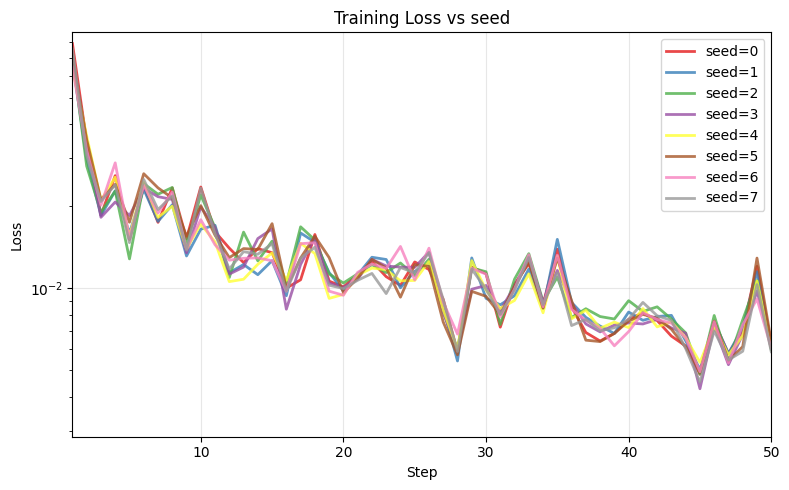


Final Results Summary:
seed=0  --  Final Loss: 0.006224
seed=1  --  Final Loss: 0.006049
seed=2  --  Final Loss: 0.005950
seed=3  --  Final Loss: 0.006215
seed=4  --  Final Loss: 0.006110
seed=5  --  Final Loss: 0.006379
seed=6  --  Final Loss: 0.006029
seed=7  --  Final Loss: 0.005851


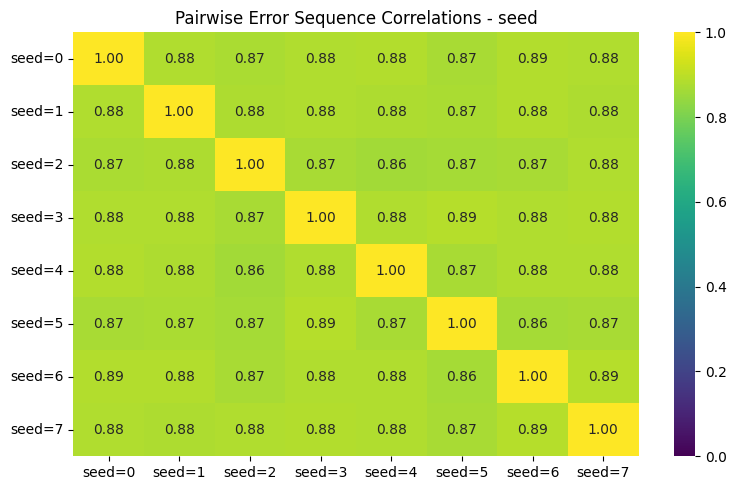

In [21]:
plot_1var_ablation_results(results, 'seed', figsize=(8, 5))
plt.show()

plot_1var_error_correlations(results, 'seed', figsize=(8, 5))
plt.show()

## Different model sizes + activations

In [ ]:
batch_size = 1
# activation_class = nn.SiLU  # Using ReLU as the activation function

activation_classes = [nn.ReLU, nn.SiLU, nn.Tanh, LTU, SinActivation, nn.LeakyReLU, nn.SELU, nn.Sigmoid]
n_layers = 3
hidden_dim_values = [20, 200]

# Run experiments
results = {}
for activation_class in activation_classes:
    for hidden_dim in hidden_dim_values:
        print(f"\nTraining model with {activation_class.__name__} activation and {hidden_dim} hidden units...")
        
        # Create layer sizes
        layer_sizes = [input_dim] + [hidden_dim] * (n_layers - 1) + [outputs.shape[1]]
        # Create model
        model = create_mlp(layer_sizes, activation_class)
        learning_rate = 0.01 / hidden_dim ** 0.5
        
        # Train model
        losses = train_model(
            model, inputs, outputs,
            repr_step_size = learning_rate,
            batch_size = 1,
            log_freq = 200,
        )
        
        # Store results
        results[(activation_class.__name__, hidden_dim)] = losses


Training model with ReLU activation and 20 hidden units...
Step 200: Loss = 0.202862
Step 400: Loss = 0.057494
Step 600: Loss = 0.033715
Step 800: Loss = 0.033863
Step 1000: Loss = 0.024085
Step 1200: Loss = 0.016106
Step 1400: Loss = 0.018157
Step 1600: Loss = 0.016698
Step 1800: Loss = 0.018320
Step 2000: Loss = 0.012484
Step 2200: Loss = 0.014552
Step 2400: Loss = 0.012696
Step 2600: Loss = 0.015961
Step 2800: Loss = 0.013731
Step 3000: Loss = 0.012813
Step 3200: Loss = 0.014238
Step 3400: Loss = 0.010921
Step 3600: Loss = 0.011432
Step 3800: Loss = 0.008893
Step 4000: Loss = 0.013809
Step 4200: Loss = 0.011285
Step 4400: Loss = 0.009364
Step 4600: Loss = 0.011730
Step 4800: Loss = 0.010077
Step 5000: Loss = 0.009886
Step 5200: Loss = 0.010829
Step 5400: Loss = 0.010298
Step 5600: Loss = 0.011348
Step 5800: Loss = 0.009489
Step 6000: Loss = 0.010655
Step 6200: Loss = 0.010346
Step 6400: Loss = 0.010298
Step 6600: Loss = 0.009884
Step 6800: Loss = 0.010272
Step 7000: Loss = 0.010642

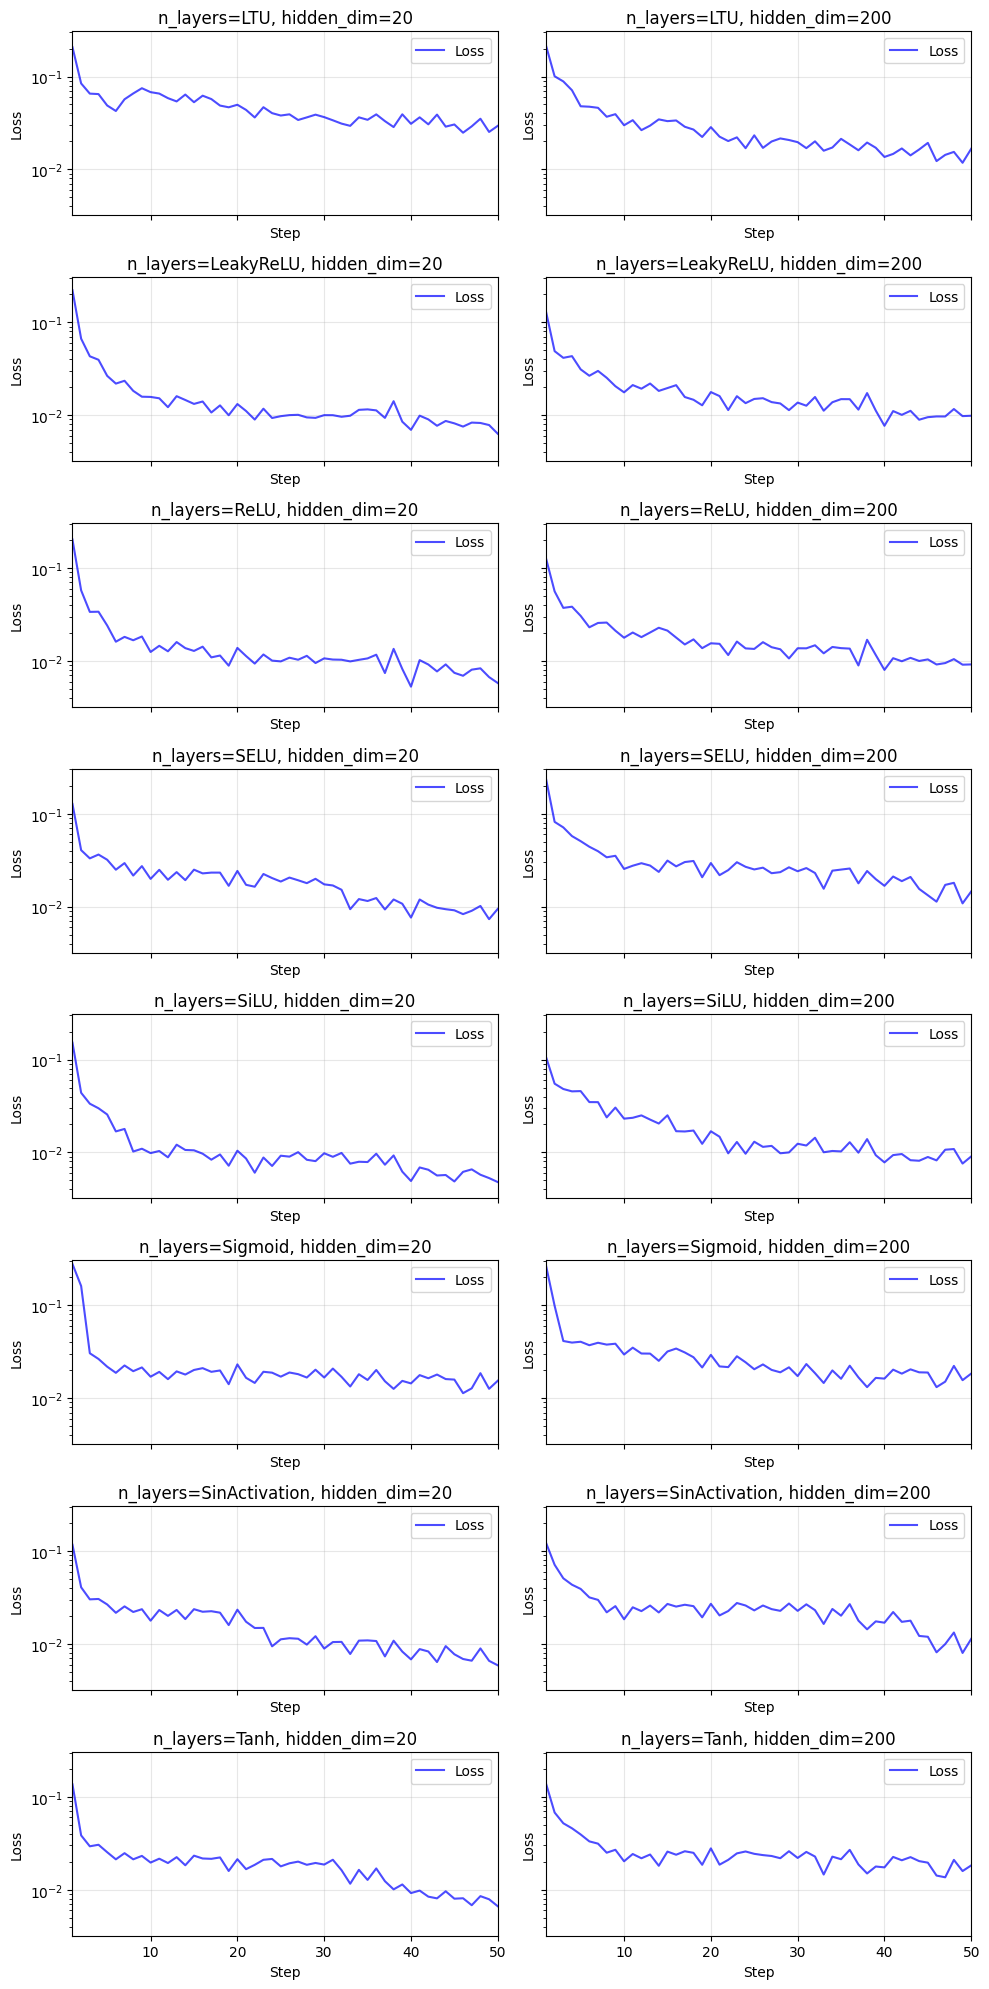


Final Results Summary:
n_layers=LTU, hidden_dim=20:
  Final Loss: 0.029431

n_layers=LTU, hidden_dim=200:
  Final Loss: 0.016698

n_layers=LeakyReLU, hidden_dim=20:
  Final Loss: 0.006310

n_layers=LeakyReLU, hidden_dim=200:
  Final Loss: 0.009854

n_layers=ReLU, hidden_dim=20:
  Final Loss: 0.005783

n_layers=ReLU, hidden_dim=200:
  Final Loss: 0.009168

n_layers=SELU, hidden_dim=20:
  Final Loss: 0.009467

n_layers=SELU, hidden_dim=200:
  Final Loss: 0.014601

n_layers=SiLU, hidden_dim=20:
  Final Loss: 0.004800

n_layers=SiLU, hidden_dim=200:
  Final Loss: 0.009068

n_layers=Sigmoid, hidden_dim=20:
  Final Loss: 0.015424

n_layers=Sigmoid, hidden_dim=200:
  Final Loss: 0.018433

n_layers=SinActivation, hidden_dim=20:
  Final Loss: 0.005895

n_layers=SinActivation, hidden_dim=200:
  Final Loss: 0.011362

n_layers=Tanh, hidden_dim=20:
  Final Loss: 0.006646

n_layers=Tanh, hidden_dim=200:
  Final Loss: 0.018296



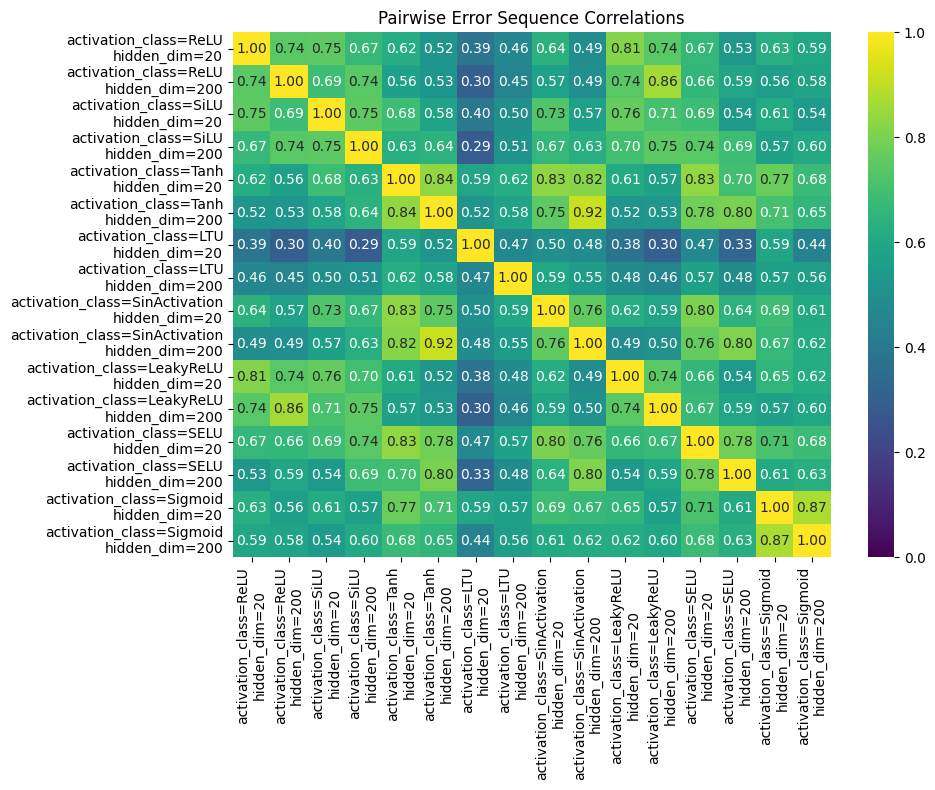

In [ ]:
plot_ablation_results(results, 'n_layers', 'hidden_dim', figsize=(10, 20))
plt.show()

plot_error_correlations(results, 'activation_class', 'hidden_dim')
plt.show()

## Different sparsity + activations

In [10]:
batch_size = 1
# activation_class = nn.SiLU  # Using ReLU as the activation function

activation_classes = [nn.ReLU, nn.SiLU, nn.Tanh, LTU, SinActivation, nn.LeakyReLU, nn.Sigmoid]
n_layers = 3
hidden_dim = 500
sparsity_rates = [0.0, 0.5, 0.9, 0.98]

# Run experiments
results = {}
for activation_class in activation_classes:
    for sparsity_rate in sparsity_rates:
        print(f"\nTraining model with {activation_class.__name__} activation and {sparsity_rate} sparsity rate...")
        
        # Create layer sizes
        layer_sizes = [input_dim] + [hidden_dim] * (n_layers - 1) + [outputs.shape[1]]
        # Create model
        model = create_mlp(
            layer_sizes,
            activation_class,
            sparsity_rate = sparsity_rate,
            small_world_sparsity = False,
        )
        learning_rate = 0.01 / hidden_dim ** 0.5
        
        # Train model
        losses = train_model(
            model, inputs, outputs,
            repr_step_size = learning_rate,
            batch_size = 1,
            log_freq = 200,
        )
        
        # Store results
        results[(activation_class.__name__, sparsity_rate)] = losses


Training model with ReLU activation and 0.0 sparsity rate...
Step 200: Loss = 0.012812
Step 400: Loss = 0.020992
Step 600: Loss = 0.002476
Step 800: Loss = 0.000429
Step 1000: Loss = 0.000271
Step 1200: Loss = 0.005852
Step 1400: Loss = 0.008514
Step 1600: Loss = 0.013014
Step 1800: Loss = 0.008619
Step 2000: Loss = 0.011015
Step 2200: Loss = 0.004505


KeyboardInterrupt: 

In [ ]:
batch_size = 1
# activation_class = nn.SiLU  # Using ReLU as the activation function

activation_classes = [nn.ReLU, nn.SiLU, nn.Tanh, LTU, SinActivation, nn.LeakyReLU, nn.SELU, nn.Sigmoid]
n_layers = 3
hidden_dim_values = [20, 200]

# Run experiments
results = {}
for activation_class in activation_classes:
    for hidden_dim in hidden_dim_values:
        print(f"\nTraining model with {activation_class.__name__} activation and {hidden_dim} hidden units...")
        
        # Create layer sizes
        layer_sizes = [input_dim] + [hidden_dim] * (n_layers - 1) + [outputs.shape[1]]
        # Create model
        model = create_mlp(layer_sizes, activation_class)
        learning_rate = 0.01 / hidden_dim ** 0.5
        
        # Train model
        losses = train_model(
            model, inputs, outputs,
            repr_step_size = learning_rate,
            batch_size = 1,
            log_freq = 200,
        )
        
        # Store results
        results[(activation_class.__name__, hidden_dim)] = losses

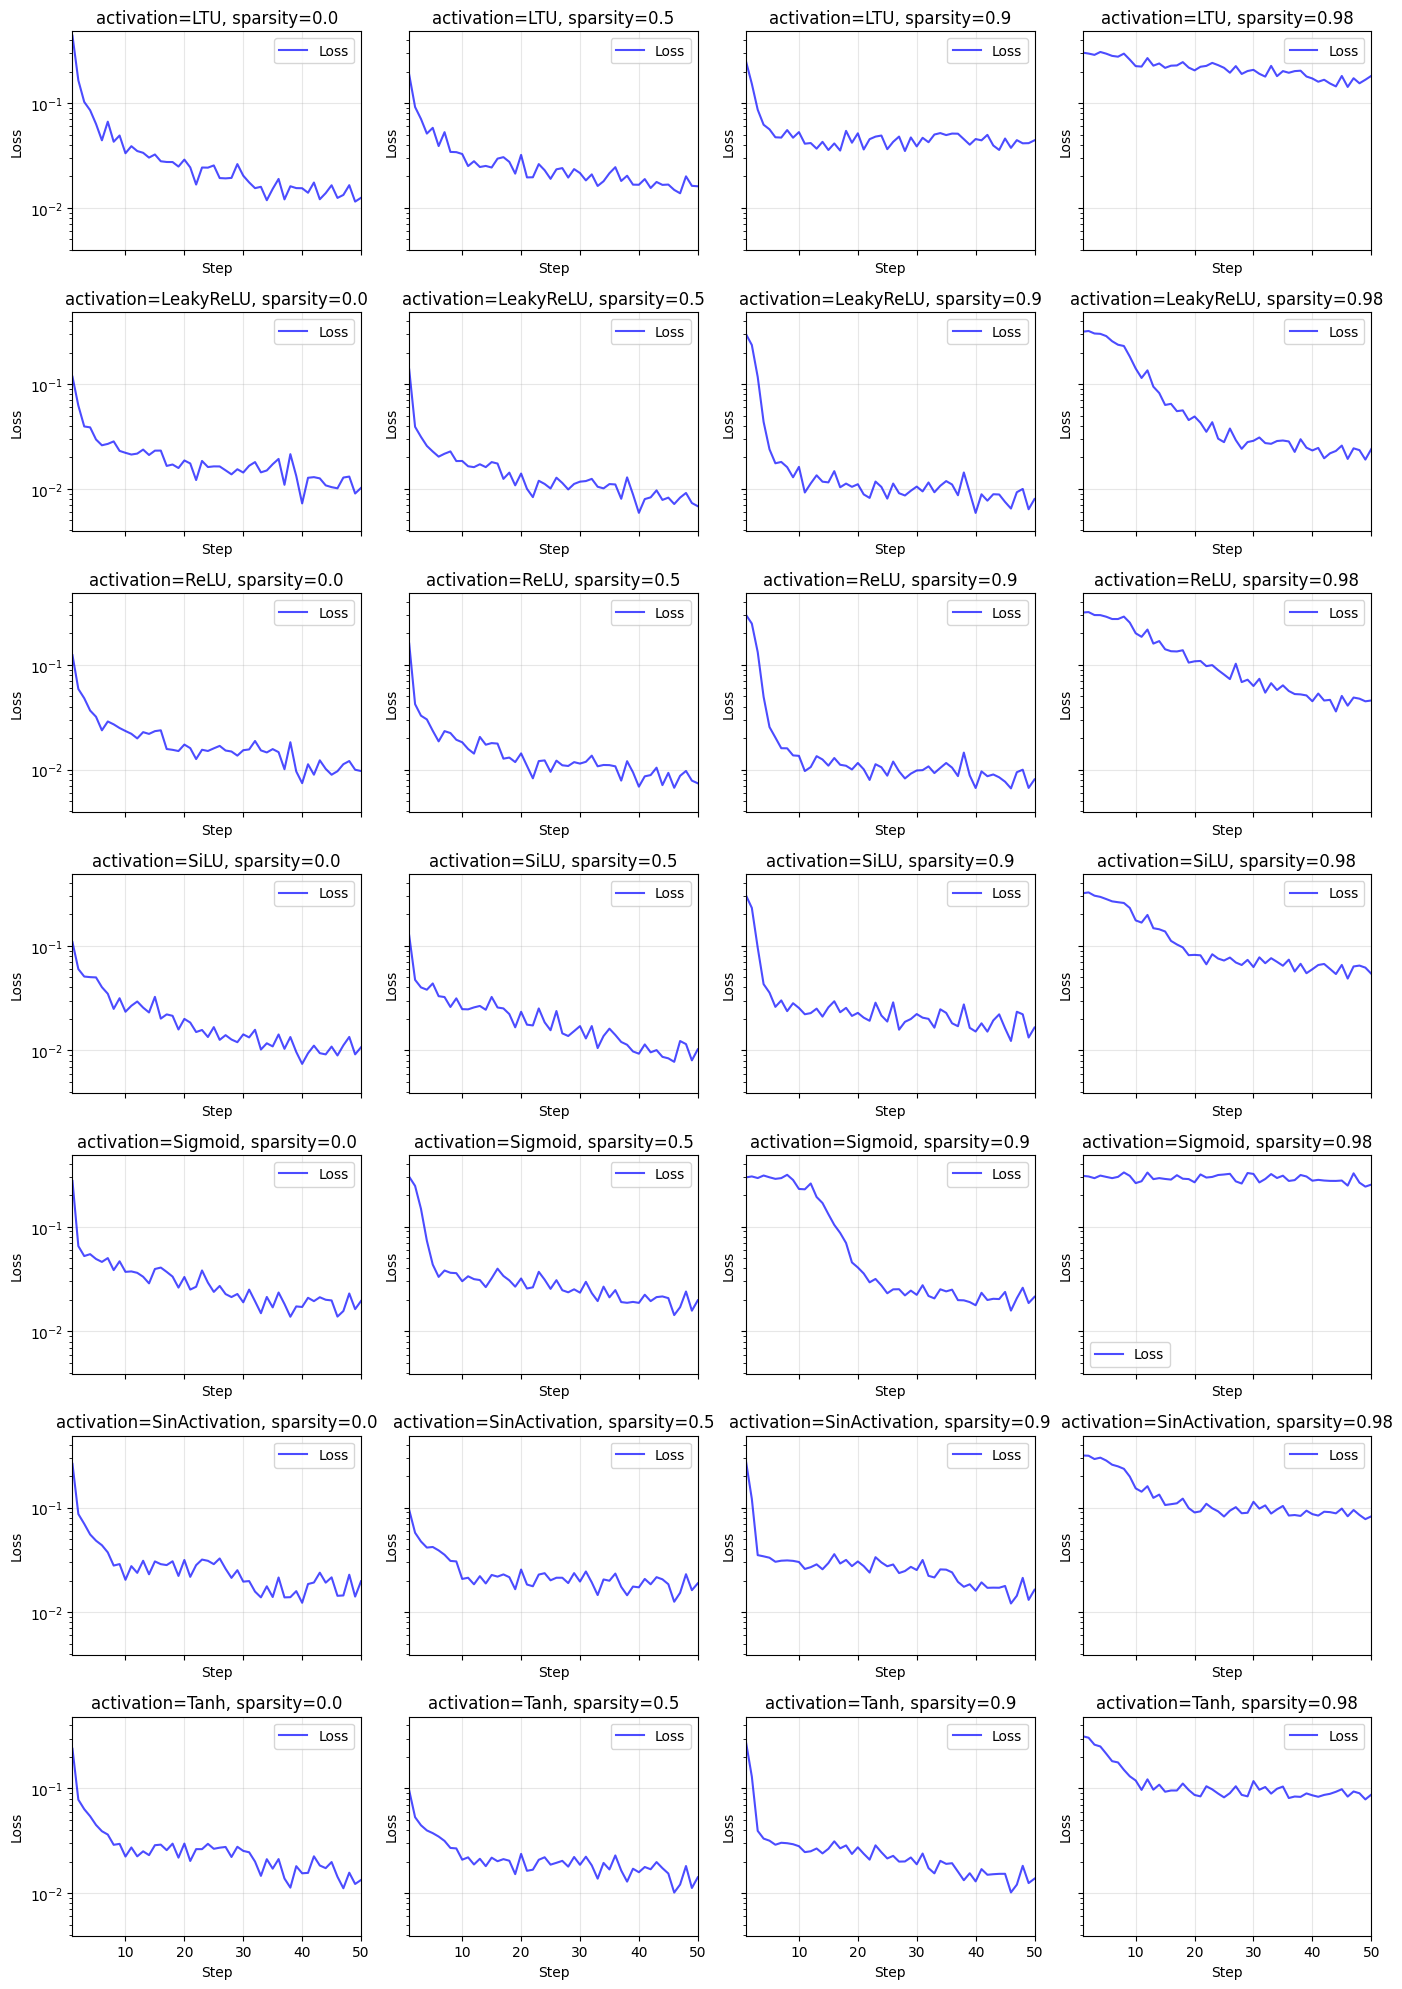


Final Results Summary:
activation=LTU, sparsity=0.0:
  Final Loss: 0.012480

activation=LTU, sparsity=0.5:
  Final Loss: 0.016075

activation=LTU, sparsity=0.9:
  Final Loss: 0.044198

activation=LTU, sparsity=0.98:
  Final Loss: 0.182400

activation=LeakyReLU, sparsity=0.0:
  Final Loss: 0.010183

activation=LeakyReLU, sparsity=0.5:
  Final Loss: 0.006813

activation=LeakyReLU, sparsity=0.9:
  Final Loss: 0.007972

activation=LeakyReLU, sparsity=0.98:
  Final Loss: 0.023890

activation=ReLU, sparsity=0.0:
  Final Loss: 0.009693

activation=ReLU, sparsity=0.5:
  Final Loss: 0.007402

activation=ReLU, sparsity=0.9:
  Final Loss: 0.008057

activation=ReLU, sparsity=0.98:
  Final Loss: 0.045764

activation=SiLU, sparsity=0.0:
  Final Loss: 0.010731

activation=SiLU, sparsity=0.5:
  Final Loss: 0.010254

activation=SiLU, sparsity=0.9:
  Final Loss: 0.016563

activation=SiLU, sparsity=0.98:
  Final Loss: 0.054145

activation=Sigmoid, sparsity=0.0:
  Final Loss: 0.019507

activation=Sigmoid

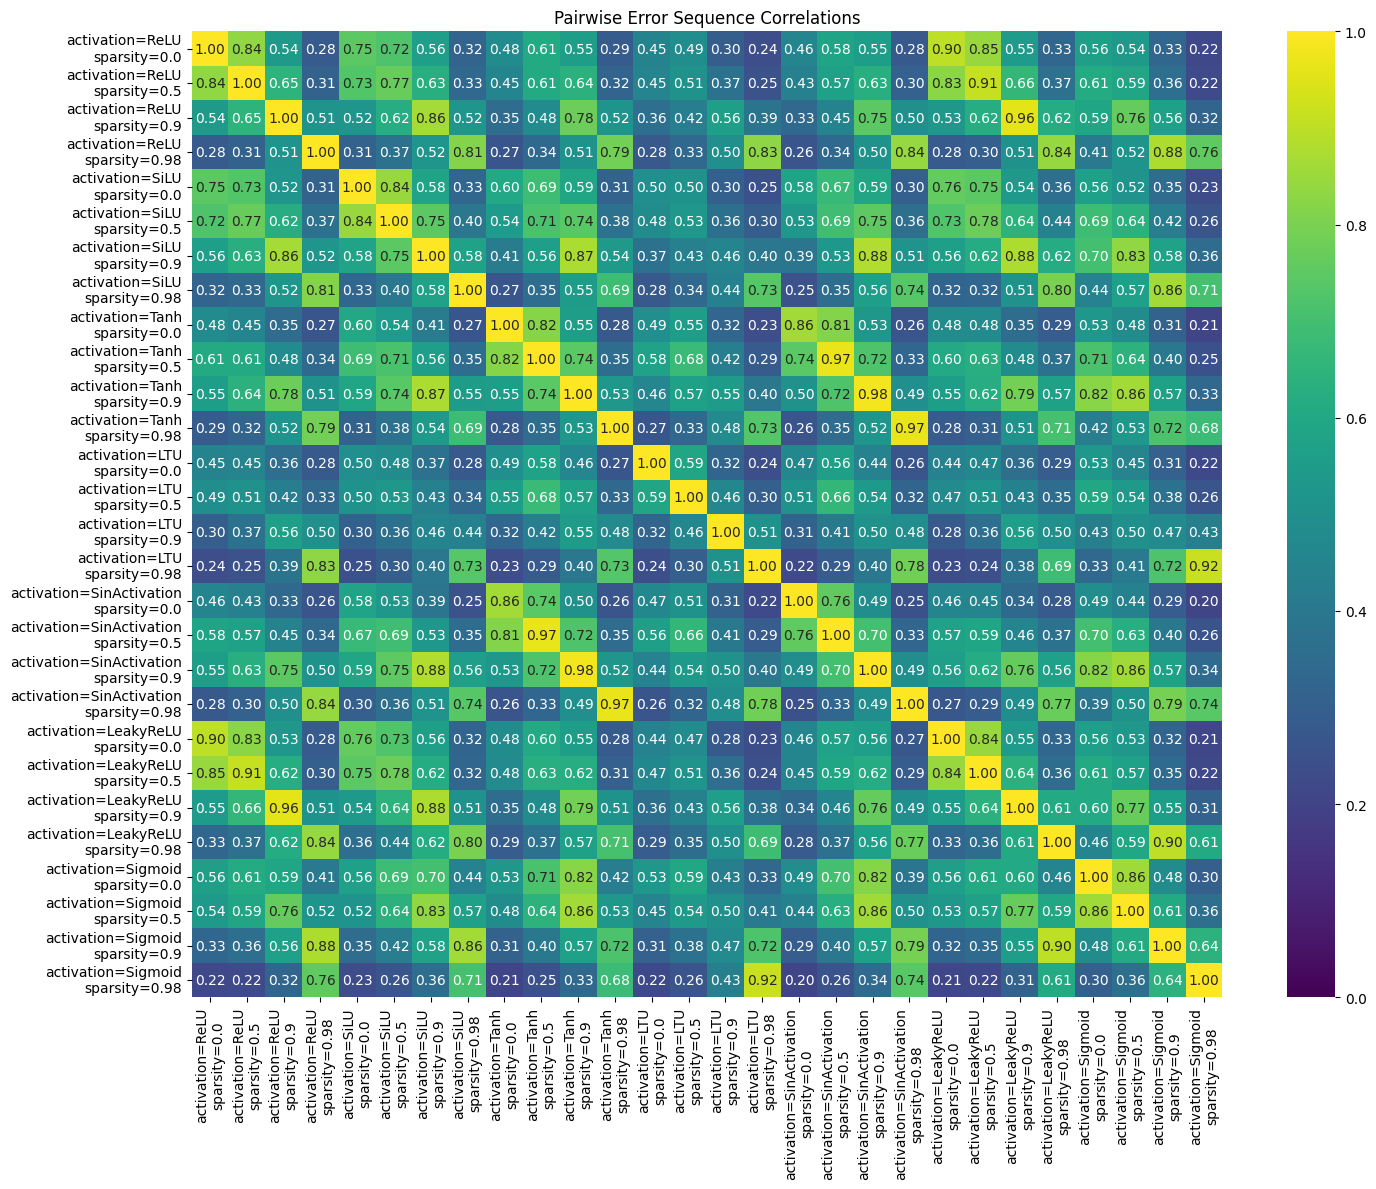

In [17]:
plot_ablation_results(results, 'activation', 'sparsity', figsize=(14, 20))
plt.show()

plot_error_correlations(results, 'activation', 'sparsity', figsize=(15, 12))
plt.show()

## Different small world sparsity rates + activatons

In [18]:
batch_size = 1
# activation_class = nn.SiLU  # Using ReLU as the activation function

activation_classes = [nn.ReLU, nn.SiLU, nn.Tanh, LTU, SinActivation, nn.LeakyReLU, nn.Sigmoid]
n_layers = 3
hidden_dim = 500
sparsity_rates = [0.0, 0.5, 0.9, 0.98]

# Run experiments
results = {}
for activation_class in activation_classes:
    for sparsity_rate in sparsity_rates:
        print(f"\nTraining model with {activation_class.__name__} activation and {sparsity_rate} sparsity rate...")
        
        # Create layer sizes
        layer_sizes = [input_dim] + [hidden_dim] * (n_layers - 1) + [outputs.shape[1]]
        # Create model
        model = create_mlp(
            layer_sizes,
            activation_class,
            sparsity_rate = sparsity_rate,
            small_world_sparsity = True,
        )
        learning_rate = 0.01 / hidden_dim ** 0.5
        
        # Train model
        losses = train_model(
            model, inputs, outputs,
            repr_step_size = learning_rate,
            batch_size = 1,
            log_freq = 200,
        )
        
        # Store results
        results[(activation_class.__name__, sparsity_rate)] = losses


Training model with ReLU activation and 0.0 sparsity rate...
Step 200: Loss = 0.123939
Step 400: Loss = 0.055602
Step 600: Loss = 0.048675
Step 800: Loss = 0.042655
Step 1000: Loss = 0.029766
Step 1200: Loss = 0.026705
Step 1400: Loss = 0.027799
Step 1600: Loss = 0.025559
Step 1800: Loss = 0.024641
Step 2000: Loss = 0.019969
Step 2200: Loss = 0.021534
Step 2400: Loss = 0.017903
Step 2600: Loss = 0.022471
Step 2800: Loss = 0.017421
Step 3000: Loss = 0.023384
Step 3200: Loss = 0.022816
Step 3400: Loss = 0.016578
Step 3600: Loss = 0.016273
Step 3800: Loss = 0.014520
Step 4000: Loss = 0.017639
Step 4200: Loss = 0.015893
Step 4400: Loss = 0.010892
Step 4600: Loss = 0.016483
Step 4800: Loss = 0.016485
Step 5000: Loss = 0.016550
Step 5200: Loss = 0.016388
Step 5400: Loss = 0.014892
Step 5600: Loss = 0.013519
Step 5800: Loss = 0.013541
Step 6000: Loss = 0.013820
Step 6200: Loss = 0.014716
Step 6400: Loss = 0.016528
Step 6600: Loss = 0.013559
Step 6800: Loss = 0.014807
Step 7000: Loss = 0.0158

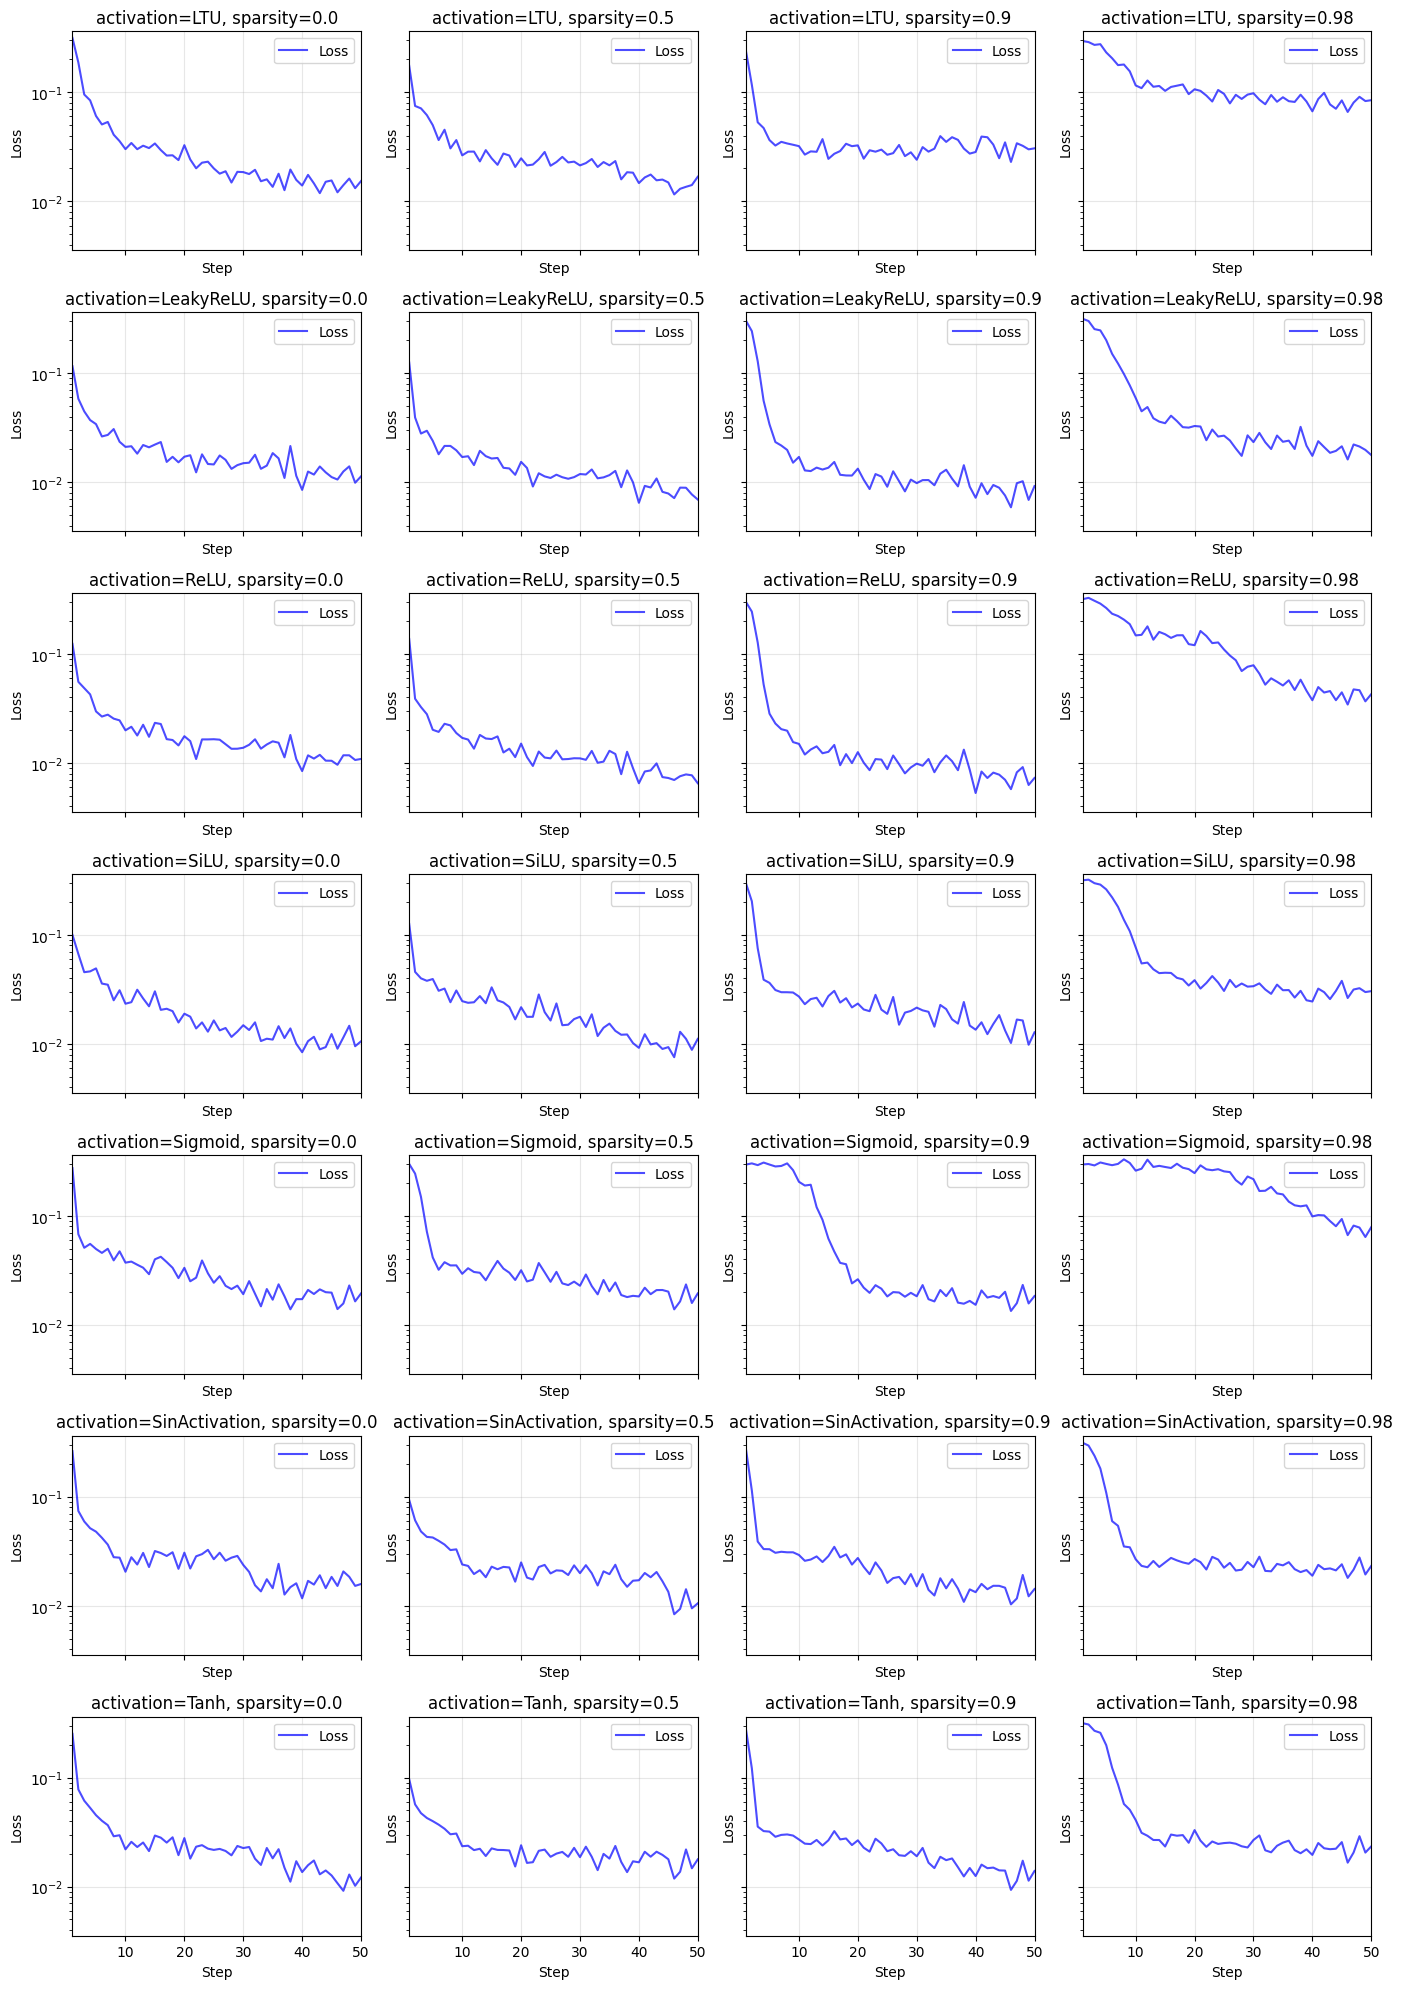


Final Results Summary:
activation=LTU, sparsity=0.0:
  Final Loss: 0.015332

activation=LTU, sparsity=0.5:
  Final Loss: 0.016808

activation=LTU, sparsity=0.9:
  Final Loss: 0.030619

activation=LTU, sparsity=0.98:
  Final Loss: 0.084602

activation=LeakyReLU, sparsity=0.0:
  Final Loss: 0.011307

activation=LeakyReLU, sparsity=0.5:
  Final Loss: 0.006939

activation=LeakyReLU, sparsity=0.9:
  Final Loss: 0.009213

activation=LeakyReLU, sparsity=0.98:
  Final Loss: 0.017754

activation=ReLU, sparsity=0.0:
  Final Loss: 0.010909

activation=ReLU, sparsity=0.5:
  Final Loss: 0.006534

activation=ReLU, sparsity=0.9:
  Final Loss: 0.007302

activation=ReLU, sparsity=0.98:
  Final Loss: 0.042857

activation=SiLU, sparsity=0.0:
  Final Loss: 0.010570

activation=SiLU, sparsity=0.5:
  Final Loss: 0.011130

activation=SiLU, sparsity=0.9:
  Final Loss: 0.012784

activation=SiLU, sparsity=0.98:
  Final Loss: 0.030494

activation=Sigmoid, sparsity=0.0:
  Final Loss: 0.019395

activation=Sigmoid

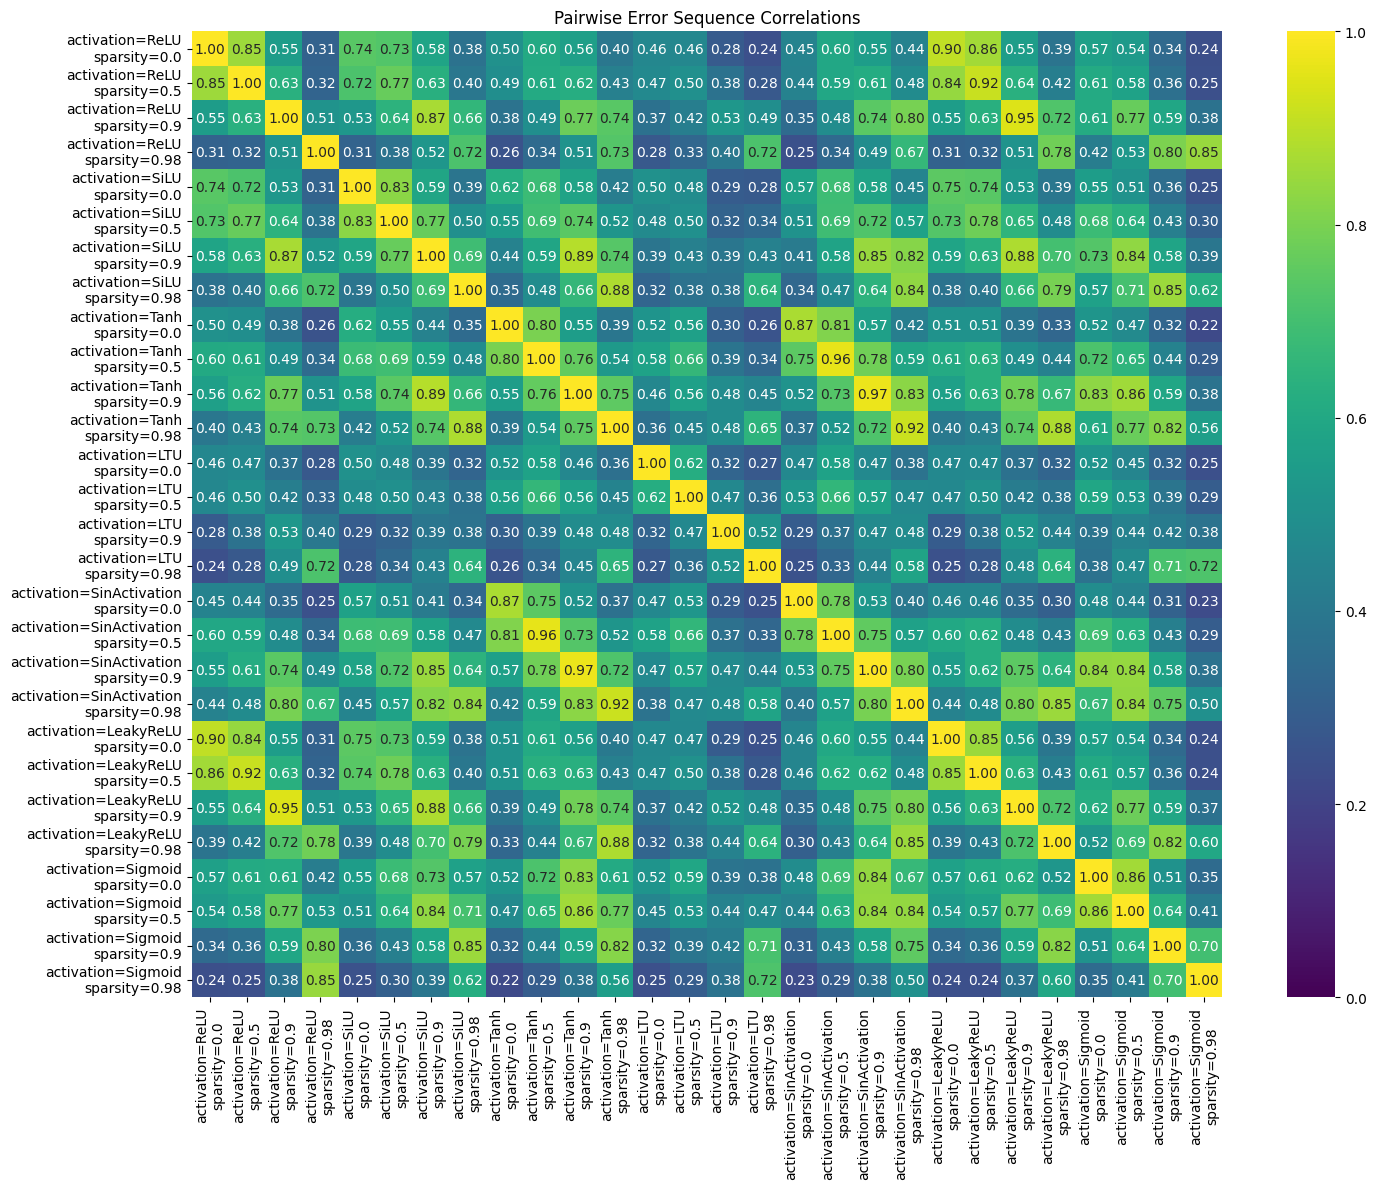

In [19]:
plot_ablation_results(results, 'activation', 'sparsity', figsize=(14, 20))
plt.show()

plot_error_correlations(results, 'activation', 'sparsity', figsize=(15, 12))
plt.show()